In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers


In [11]:
import pandas as pd
# Load the dataset
data = pd.read_csv("Infrared.csv")
# Display the first few rows to understand its structure
data.head()

,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,...,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,aveOralM
0,Male,41-50,White,24.0,28.0,0.8,0.7025,35.0300,35.3775,34.4000,...,33.4775,33.3725,33.4925,33.0025,34.5300,34.0075,35.6925,35.6350,35.6525,36.59
1,Female,31-40,Black or African-American,24.0,26.0,0.8,0.7800,34.5500,34.5200,33.9300,...,34.0550,33.6775,33.9700,34.0025,34.6825,34.6600,35.1750,35.0925,35.1075,37.19
2,Female,21-30,White,24.0,26.0,0.8,0.8625,35.6525,35.5175,34.2775,...,34.8275,34.6475,34.8200,34.6700,35.3450,35.2225,35.9125,35.8600,35.8850,37.34
3,Female,21-30,Black or African-American,24.0,27.0,0.8,0.9300,35.2225,35.6125,34.3850,...,34.4225,34.6550,34.3025,34.9175,35.6025,35.3150,35.7200,34.9650,34.9825,37.09
4,Male,18-20,White,24.0,27.0,0.8,0.8950,35.5450,35.6650,34.9100,...,35.1600,34.3975,34.6700,33.8275,35.4175,35.3725,35.8950,35.5875,35.6175,37.04


In [12]:
# Drop rows with missing values
data = data.dropna()

In [13]:
# Defining the categorical and numerical columns
categorical_columns = ["Gender", "Age", "Ethnicity"]
numerical_columns = list(set(data.columns) - set(categorical_columns) - {"aveOralM"})

In [14]:
# Handling missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

data[categorical_columns] = cat_imputer.fit_transform(data[categorical_columns])
data[numerical_columns] = num_imputer.fit_transform(data[numerical_columns])

In [15]:
# One-Hot Encoding for categorical data
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_data = encoder.fit_transform(data[categorical_columns])
categorical_df = pd.DataFrame(categorical_data, columns=encoder.get_feature_names_out(categorical_columns))


In [16]:
# Normalizing the numerical features
scaler_X = StandardScaler()
numerical_data = scaler_X.fit_transform(data[numerical_columns])
numerical_df = pd.DataFrame(numerical_data, columns=numerical_columns)

In [17]:
# Normalizing the target variable
scaler_y = StandardScaler()
target = scaler_y.fit_transform(data[["aveOralM"]]).flatten()

In [18]:
# Combining numerical and categorical features
features = pd.concat([numerical_df, categorical_df], axis=1)

In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [20]:
# Converting to PyTorch tensors
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch = torch.tensor(X_test.values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


# Model Deeplearning Menggunakan PyTorch

In [21]:
# Build a simple neural network model
class PyTorchModel(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [22]:
# Initialize the model
model = PyTorchModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)


In [23]:
# Training the model
for epoch in range(500):
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}')

Epoch [100/500], Loss: 0.1197
Epoch [200/500], Loss: 0.0641
Epoch [300/500], Loss: 0.0494
Epoch [400/500], Loss: 0.0398
Epoch [500/500], Loss: 0.0407


In [29]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_torch)

In [30]:
# Calculate RMSE, MSE, and R^2
y_pred_test_np = y_pred_test.numpy()
y_test_np = y_test_torch.numpy()

mse = mean_squared_error(y_test_np, y_pred_test_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_test_np)

In [31]:
# Display results
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

RMSE: 0.5296
MSE: 0.2805
R^2: 0.6339


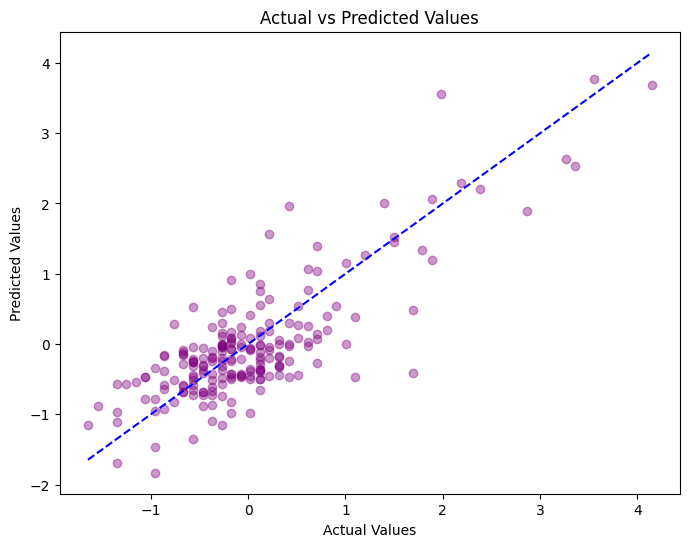

In [43]:
# Plot Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, y_pred_test_np, alpha=0.4, color='purple')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], color='blue', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


# Model Deeplearning Menggunakan TensorFlow

In [44]:
# Build a neural network model using TensorFlow (Keras)
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Training model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.4443 - val_loss: 0.2479
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3454 - val_loss: 0.3154
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2993 - val_loss: 0.2311
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2313 - val_loss: 0.3848
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2670 - val_loss: 0.2634
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2447 - val_loss: 0.2489
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2257 - val_loss: 0.2479
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1925 - val_loss: 0.2349
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1856 - val_loss: 0.2875
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2026 - val_loss: 0.2407
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1787 - val_loss: 0.2498
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

In [48]:
# Evaluate the model
y_pred_test = model.predict(X_test)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [49]:
# Calculate MSE, RMSE, dan R²
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_test)

In [50]:
# Display results
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

RMSE: 0.5779
MSE: 0.3340
R^2: 0.5642


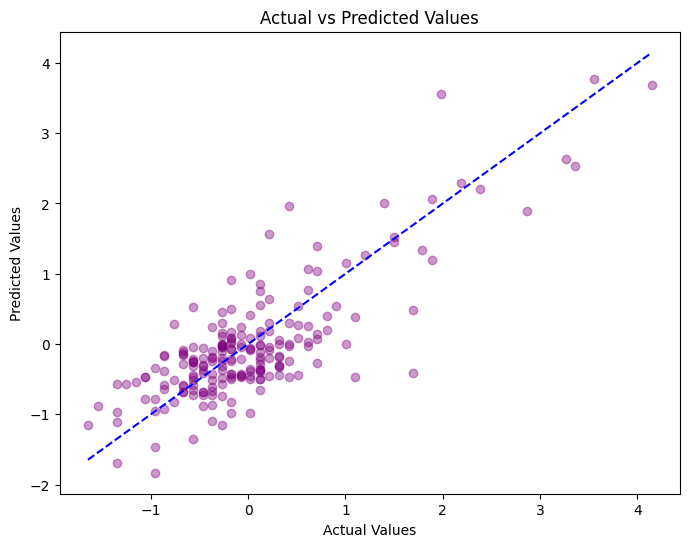

In [51]:
# Plot Predicted vs Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_np, y_pred_test_np, alpha=0.4, color='purple')
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], color='blue', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


# Penjelasan Model Deep Learning (PyTorch dan TensorFlow)

## 1. Model Deep Learning:

### **PyTorch Model:**
Model ini dibangun menggunakan arsitektur lapisan jaringan saraf (neural network layers) dengan 4 lapisan penuh (fully connected layers). Model ini memiliki input layer dengan jumlah fitur yang sama dengan jumlah kolom pada `X_train`. Lapisan-lapisan tersembunyi (hidden layers) menggunakan fungsi aktivasi ReLU, dan output layer hanya memiliki satu neuron untuk memprediksi variabel target (`aveOralM`).

**Struktur lapisan model PyTorch:**
- Layer 1: 256 neuron, fungsi aktivasi ReLU
- Layer 2: 128 neuron, fungsi aktivasi ReLU
- Layer 3: 64 neuron, fungsi aktivasi ReLU
- Layer 4: 32 neuron, fungsi aktivasi ReLU
- Output: 1 neuron (output nilai prediksi)

### **TensorFlow Model:**
Model ini dibangun dengan menggunakan API `Sequential` dari Keras. Model ini memiliki arsitektur yang mirip dengan model PyTorch, yaitu dengan beberapa lapisan tersembunyi yang menggunakan fungsi aktivasi ReLU.

**Struktur lapisan model TensorFlow:**
- Layer 1: 256 neuron, fungsi aktivasi ReLU
- Layer 2: 128 neuron, fungsi aktivasi ReLU
- Layer 3: 64 neuron, fungsi aktivasi ReLU
- Layer 4: 32 neuron, fungsi aktivasi ReLU
- Output: 1 neuron (output nilai prediksi)

Kedua model menggunakan teknik optimasi Adam optimizer dan menggunakan Mean Squared Error (MSE) sebagai fungsi kerugian.

---

## 2. Matriks Evaluasi (RMSE, MSE, R²)


### **MSE (Mean Squared Error):**
MSE adalah rata-rata dari kuadrat selisih antara nilai yang diprediksi oleh model dan nilai aktual. Rumus MSE:

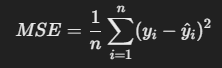

Dimana:
- yi adalah nilai aktual.
- y^i adalah nilai prediksi.
- n adalah jumlah sampel.


### **RMSE (Root Mean Squared Error):**
RMSE adalah akar kuadrat dari MSE dan memberikan ukuran kesalahan yang lebih mudah dipahami, karena berada dalam satuan yang sama dengan target variabel.

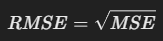

### **R² (Koefisien Determinasi):**
R² mengukur seberapa baik model menjelaskan variasi dalam data. Nilai R² berkisar antara 0 (tidak ada hubungan) hingga 1 (hubungan sempurna).

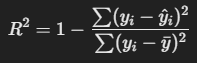

Dimana:
- yi adalah nilai aktual
- y^i adalah nilai prediksi
- y- adalah rata-rata nilai aktual